**<h2>Mask RCNN Object Detection</h2>**

**Imports**

In [1]:
import os
import sys
import random
import cv2
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import numpy

# Fixed: numpy no attribute 'bool' for numpy version > 20+
numpy.bool = numpy.bool_
np.bool = np.bool_

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN_TF2")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from Mask_RCNN_TF2.mrcnn import utils, visualize
from Mask_RCNN_TF2.mrcnn import model as modellib
# from mrcnn import utils
# import mrcnn.model as modellib
# from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
# import coco
from Mask_RCNN_TF2.samples.coco import coco

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

**Config**

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

**Create Model**

In [3]:
import tensorflow as tf
import keras
import h5py
print(tf.__version__)
print(keras.__version__)
print(h5py.__version__)

2.13.0
2.13.1
3.9.0


In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Use fn_output_signature instead


**Class Names**

In [5]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

**Object Detection**

Processing 1 images
image                    shape: (350, 800, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


d:\learning\research\Image-Classification-Object-Detection-and-Segmentation\.venv\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


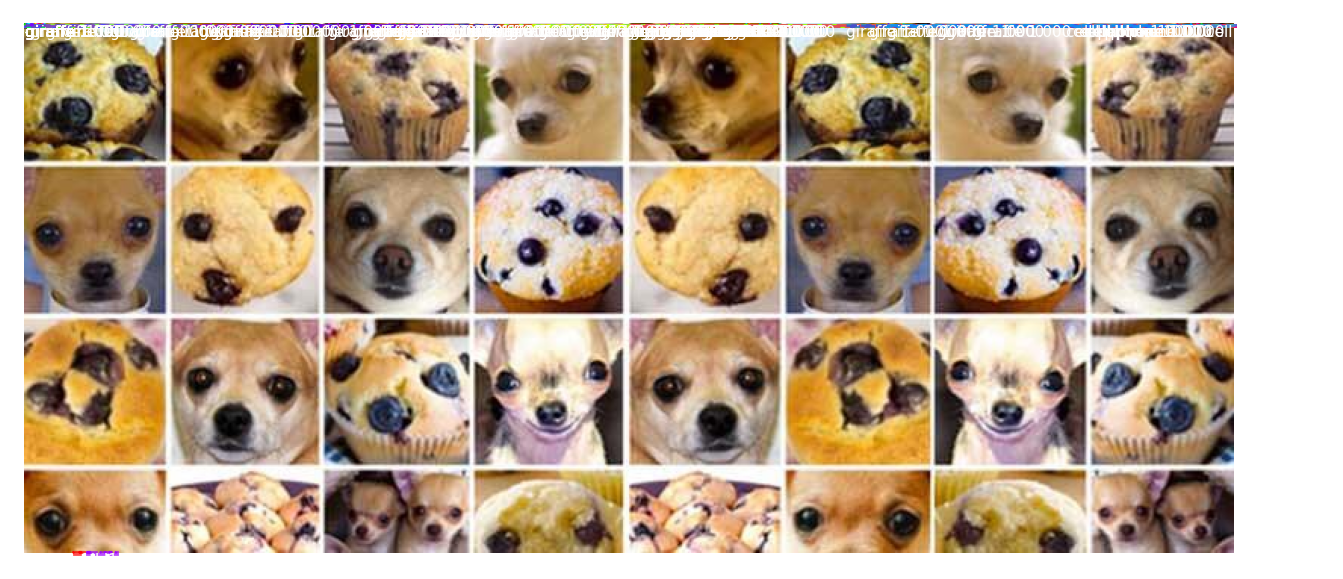

In [6]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

**Display Masks**

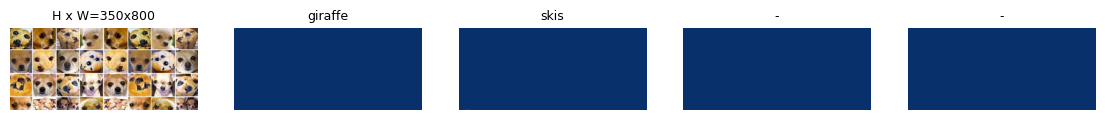

In [7]:
visualize.display_top_masks(image, r['masks'], r['class_ids'], class_names)

In [8]:
masks = {}

for i in range(len(results[0]['class_ids'])):
    masks[i] = {}
    masks[i]['mask'] = np.array(results[0]['masks'][:, :, i], dtype=np.uint8) * 255

In [9]:
def display_rois_with_scores(image, rois, class_ids,  scores, class_names=None, figsize=(5, 5), show_mask=True):
    """
    Display regions of interest (ROIs) along with their class labels, confidence scores, and masks.
    
    image: Input image (numpy array)
    rois: Array of ROIs in format (y1, x1, y2, x2)
    class_ids: Array of class IDs for each ROI
    masks: Array of masks for each ROI
    scores: Array of confidence scores for each ROI
    class_names: List of class names (optional)
    figsize: Figure size (optional)
    show_mask: Show masks or not (optional)
    """
    N = len(rois)
    
    for i in range(N):
        roi = rois[i]
        class_id = class_ids[i]
        score = scores[i]
        class_name = class_names[class_id] if class_names else f"Class {class_id}"
        
        fig, ax = plt.subplots(1, figsize=figsize)
        
        # Display ROI
        plt.imshow(image[roi[0]:roi[2], roi[1]:roi[3]])
        plt.xticks([])
        plt.yticks([])
        
        # Display class label, score, and mask
        label = f"{class_name} - {score:.2f}"
        plt.title(label)
        
        plt.axis('off')
        plt.show()

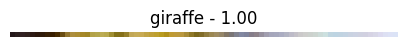

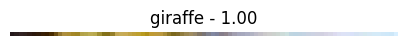

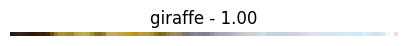

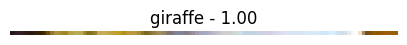

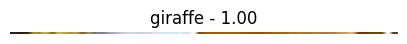

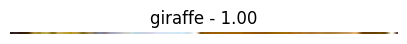

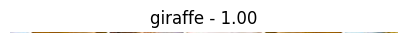

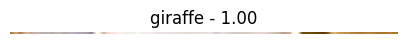

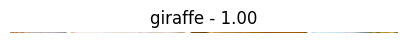

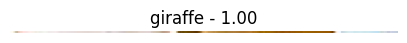

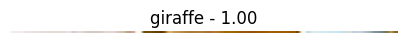

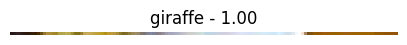

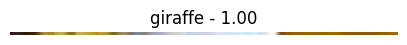

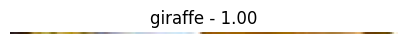

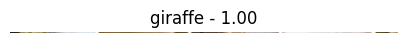

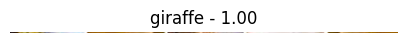

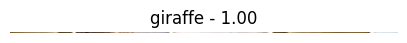

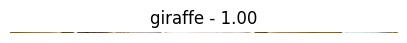

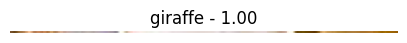

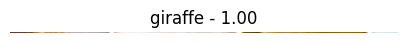

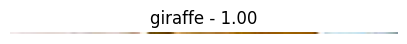

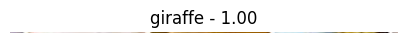

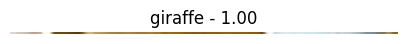

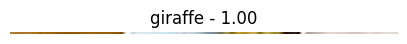

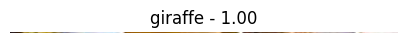

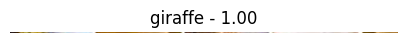

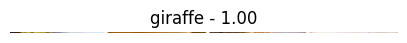

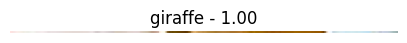

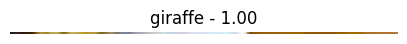

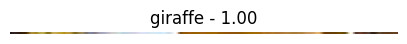

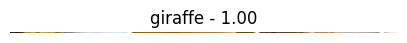

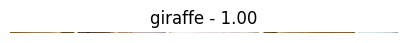

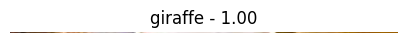

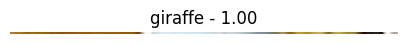

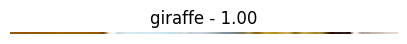

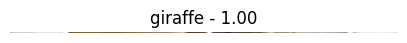

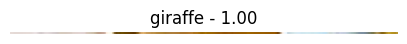

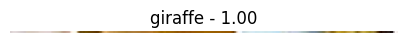

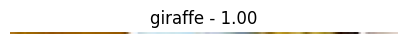

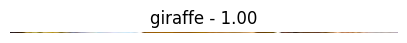

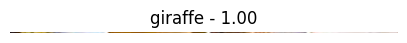

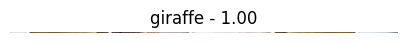

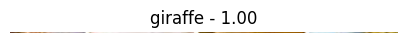

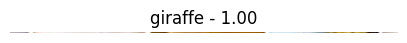

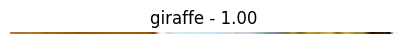

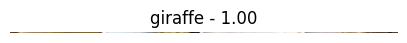

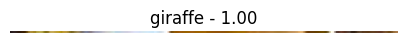

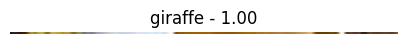

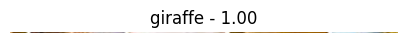

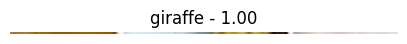

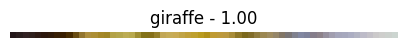

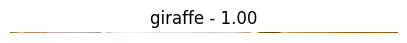

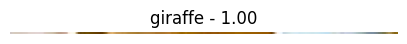

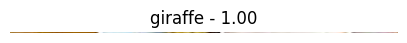

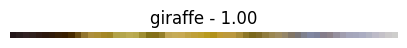

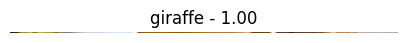

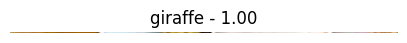

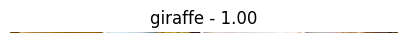

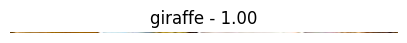

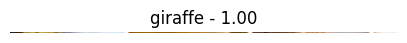

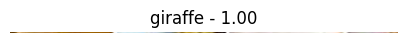

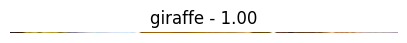

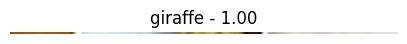

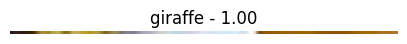

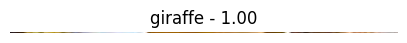

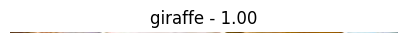

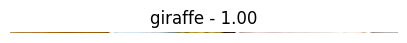

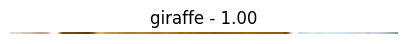

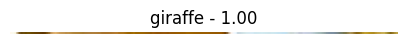

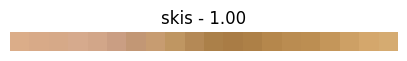

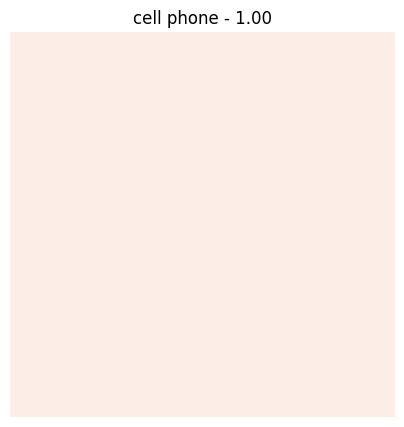

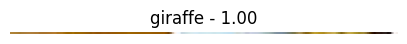

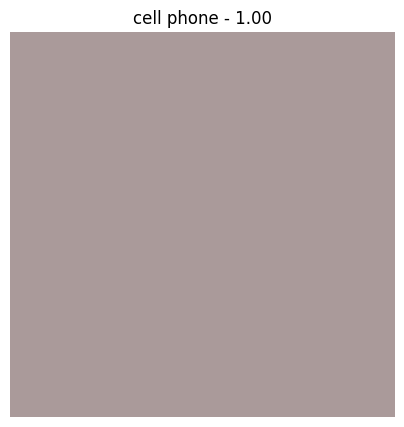

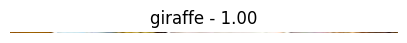

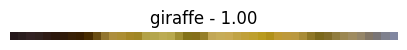

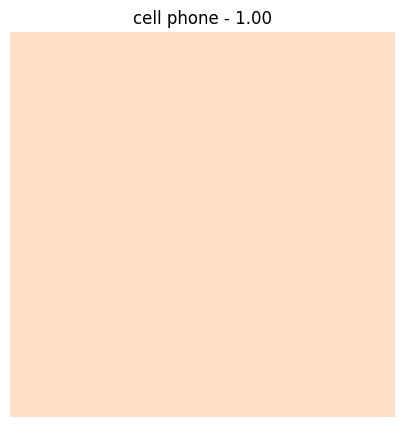

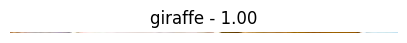

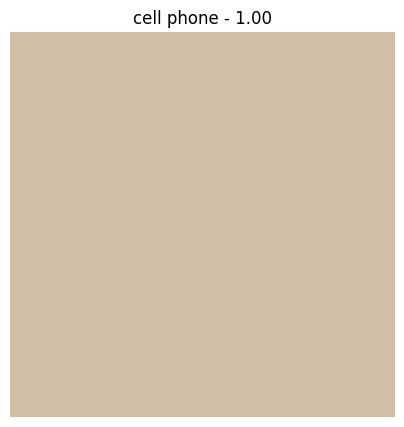

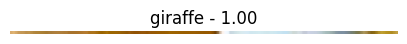

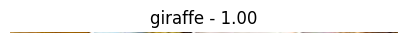

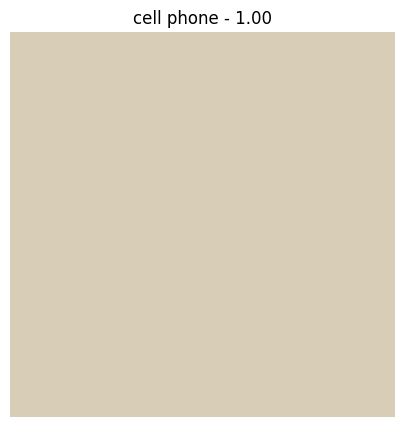

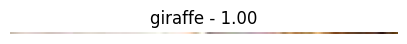

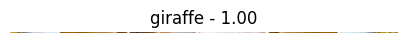

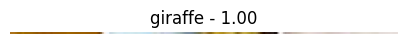

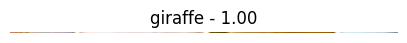

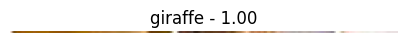

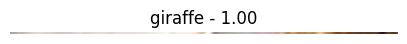

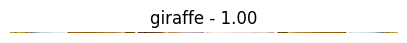

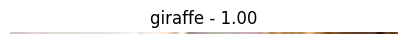

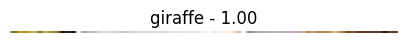

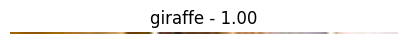

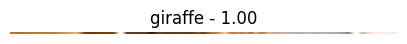

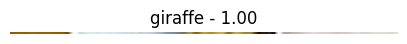

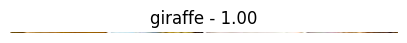

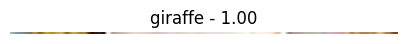

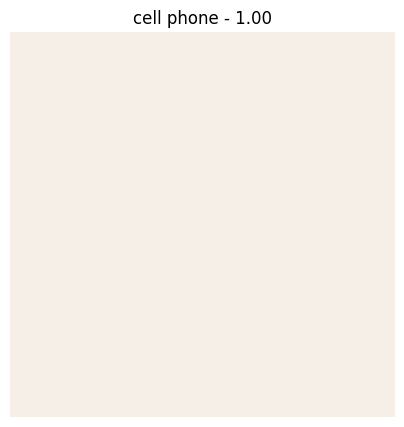

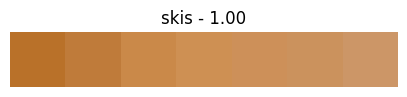

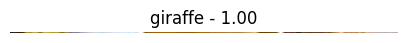

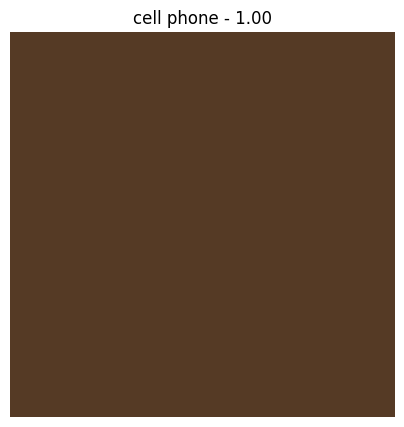

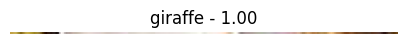

In [10]:
display_rois_with_scores(image, r['rois'], r['class_ids'], r['scores'], class_names)